In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.optimizers import Adam
import easydict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#노트북안에 그리기
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘띄도록 ggplot 을 이용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

## 변수 설명
 - country : The country that the wine is from
 - description : A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
 - designation : The vineyard within the winery where the grapes that made the wine are from
 - points : The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
 - price : The cost for a bottle of the wine
 - province : The province or state that the wine is from
 - region_1 : The wine growing area in a province or state (ie Napa)
 - region_2 : Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
 - variety : The type of grapes used to make the wine (ie Pinot Noir)
 - winery : The place where wine is made.

## 기본파라미터 및 변수정의

In [2]:
# feature로 이용할 컬럼 정의
COLUMNS = ['country', 'description', 'designation', 'points', 'price', 'province','region_1', 'region_2', 'variety', 'winery']
# ?          
LABEL_COLUMN = "label"
# 범주형 Feature
CATEGORICAL_COLUMNS = ['country', 'description', 'designation', 'province','region_1', 'region_2', 'variety', 'winery']
# 숫자형 Feature
NUMERICAL_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
# 메모리오류로 인해 df_wine_size size 만큼만 데이터를 사용함
df_wine_size=10000

## WINE Data Load

In [3]:
df_wine = pd.read_csv('wine_data.csv',index_col=None,skipinitialspace=True)
df_wine.drop('Unnamed: 0',axis=1 , inplace=True)

## EDA 수행

### EDA01
 * shape 확인

In [4]:
df_wine.shape

(150929, 10)

### EDA02
 * df_wine 의 null 컬럼 확인 및 제거

In [5]:
print('='*30,'NA Column제거전','='*30)
print(np.sum(df_wine.isna()))
df_wine.dropna(axis=0,inplace=True)
#df_wine = df_wine[:df_wine_size]
print('='*30,'NA Column제거후','='*30)
print(np.sum(df_wine.isna()))
print('df_wine shape :',df_wine.shape)
# POINT 92 점 이상을 1 , 미만을 0으로 설정
df_wine[LABEL_COLUMN] = df_wine['points'].apply(lambda x: 1 if x >=92 else 0)

============================== NA Column제거전 ==============================
country            5
description        0
designation    45734
points             0
price          13695
province           5
region_1       25059
region_2       89976
variety            0
winery             0
dtype: int64
============================== NA Column제거후 ==============================
country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64
df_wine shape : (39241, 10)


### EDA03
 * df_wine 10개 ROW 데이터 확인

In [6]:
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,label
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,1
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,1


### EDA04
 * df_wine featrue 의 정보를 확인

In [7]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150915
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39241 non-null  object 
 1   description  39241 non-null  object 
 2   designation  39241 non-null  object 
 3   points       39241 non-null  int64  
 4   price        39241 non-null  float64
 5   province     39241 non-null  object 
 6   region_1     39241 non-null  object 
 7   region_2     39241 non-null  object 
 8   variety      39241 non-null  object 
 9   winery       39241 non-null  object 
 10  label        39241 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


### EDA05
 * numerical featrue 의 통계정보

In [8]:
df_wine.describe()

,points,price,label
count,39241.000000,39241.000000,39241.000000
mean,88.359981,37.546316,0.207309
std,3.438542,26.716547,0.405384
min,80.000000,4.000000,0.000000
25%,86.000000,22.000000,0.000000
50%,88.000000,32.000000,0.000000
75%,91.000000,45.000000,0.000000
max,100.000000,2013.000000,1.000000


### EDA06
 * CATEGORICAL featrue 의 분포 상위 10개의 갯수 확인

In [9]:
for col_nm in CATEGORICAL_COLUMNS:
    df_cnt = pd.DataFrame(df_wine[col_nm].value_counts())
    df_cnt.reset_index(inplace=True)
    df_cnt.columns = [col_nm,'counts']
    display(df_cnt.head(10))

,country,counts
0,US,39241


,description,counts
0,"Very good for its complexity, although it's to...",4
1,This lovely Sauvignon Blanc is a little sweet ...,4
2,"An unusual blend of Riesling, Huxelrebe, Viogn...",4
3,"Fruity, dry and immediately appealing, showing...",4
4,"A delicious, balanced Pinot Noir. Shows dry, p...",4
5,"Dark and jellied, with raspberry and vanilla f...",4
6,"A worthy followup to the 2008, showing crisp a...",4
7,"This superrich wine, with 12.7% residual sugar...",4
8,The nose offers plenty of cooked plum preserve...,4
9,"Simple and fruity, this is a pleasant, easy-dr...",4


,designation,counts
0,Reserve,1848
1,Estate,1374
2,Estate Grown,396
3,Old Vine,256
4,Dry,254
5,Estate Bottled,249
6,Bien Nacido Vineyard,195
7,Barrel Select,116
8,Estate Reserve,112
9,Late Harvest,111


,province,counts
0,California,28557
1,Washington,6122
2,Oregon,3037
3,New York,1525


,region_1,counts
0,Napa Valley,3509
1,Columbia Valley (WA),2883
2,Russian River Valley,2630
3,Paso Robles,2095
4,California,1587
5,Willamette Valley,1388
6,Dry Creek Valley,1022
7,Sonoma Coast,1009
8,Sonoma County,947
9,Carneros,896


,region_2,counts
0,Central Coast,9150
1,Sonoma,7786
2,Columbia Valley,5785
3,Napa,5108
4,Willamette Valley,2385
5,California Other,1622
6,Mendocino/Lake Counties,1508
7,Sierra Foothills,1130
8,Napa-Sonoma,1018
9,Finger Lakes,945


,variety,counts
0,Pinot Noir,7442
1,Chardonnay,4892
2,Cabernet Sauvignon,4889
3,Red Blend,2934
4,Zinfandel,2814
5,Syrah,2791
6,Bordeaux-style Red Blend,1647
7,Merlot,1482
8,Sauvignon Blanc,1190
9,Riesling,1013


,winery,counts
0,Williams Selyem,302
1,Testarossa,264
2,Kendall-Jackson,214
3,Columbia Crest,212
4,Chateau Ste. Michelle,158
5,De Loach,157
6,Concannon,149
7,Cameron Hughes,143
8,Iron Horse,141
9,Morgan,133


### EDA07
 * points , price 의 분포를 확인

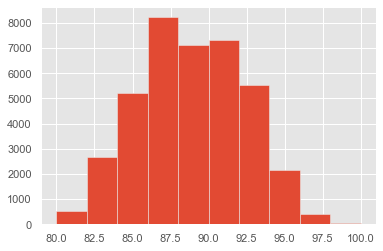

In [10]:
df_wine['points'].value_counts().shape
df_wine['points'].hist()
plt.show()

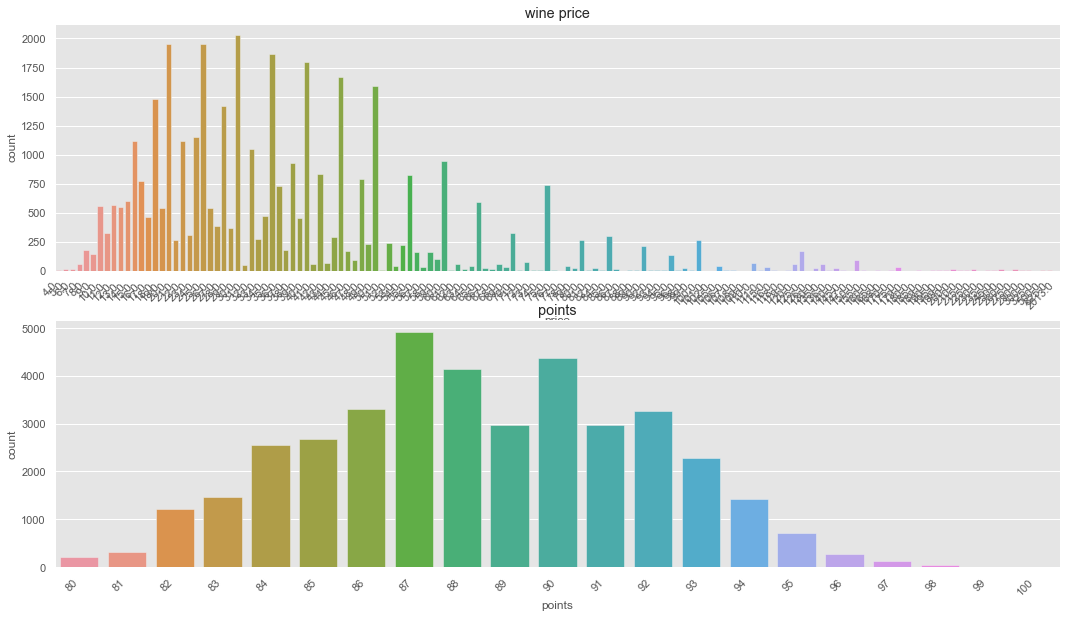

In [11]:
fig , axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')  # 글씨 45도 기울이게  글씨 겹쳐보이지 않도록 함
axes[0].set(ylabel='Count', title="wine price")
sns.countplot(data=df_wine, x="price" , ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')
axes[1].set(ylabel='Count', title="points")
sns.countplot(data=df_wine, x="points" , ax=axes[1])
plt.show()

### EDA08
 * CATEGORICAL featrue 의 상위 20개의 분포 시각화

In [12]:
def show_cat_barplot(col_nm):
    df_cnt = pd.DataFrame(df_wine[col_nm].value_counts())
    df_cnt.reset_index(inplace=True)
    df_cnt.columns = [col_nm,'counts']
    plt.xticks(rotation=45, ha='right')
    display(sns.barplot(data=df_cnt.head(20),x=col_nm,y='counts'))
    plt.show()

<AxesSubplot:xlabel='country', ylabel='counts'>

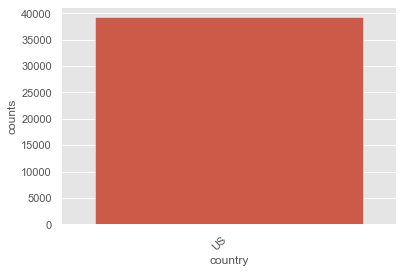

<AxesSubplot:xlabel='designation', ylabel='counts'>

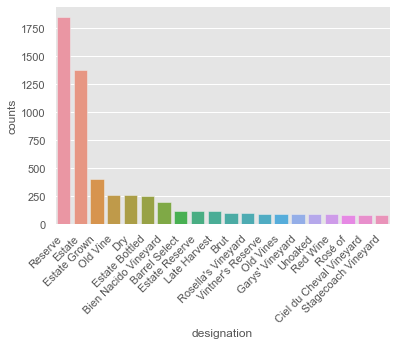

<AxesSubplot:xlabel='province', ylabel='counts'>

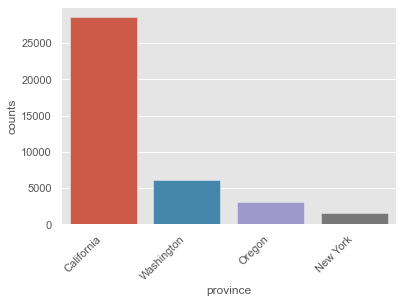

<AxesSubplot:xlabel='region_1', ylabel='counts'>

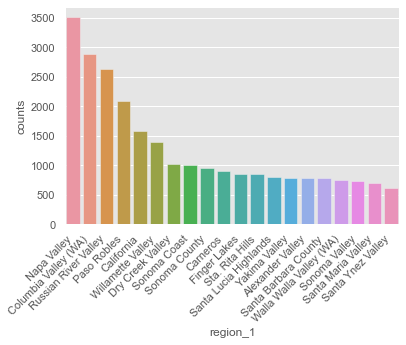

<AxesSubplot:xlabel='region_2', ylabel='counts'>

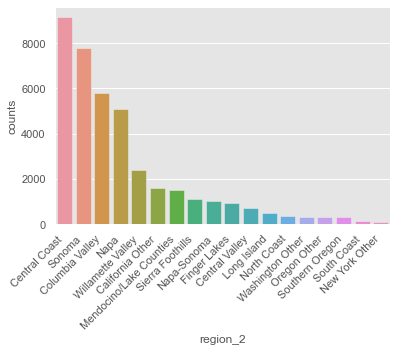

<AxesSubplot:xlabel='variety', ylabel='counts'>

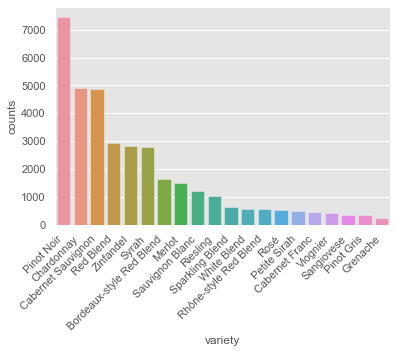

<AxesSubplot:xlabel='winery', ylabel='counts'>

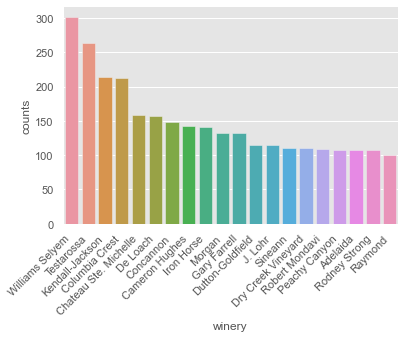

In [13]:
for col_nm in CATEGORICAL_COLUMNS:
    if col_nm != 'description':
        show_cat_barplot(col_nm)

### EDA09
 * NUMERICAL featrue 의 label (추천/비추천) 분포확인

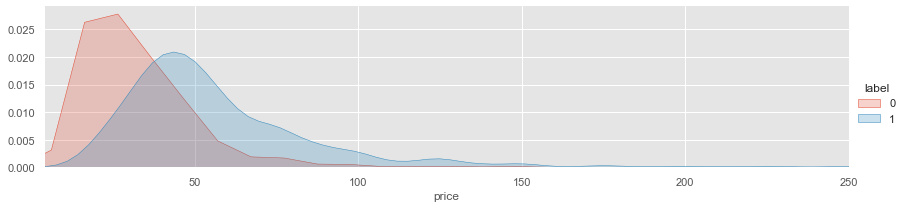

In [14]:
#	price
facet = sns.FacetGrid(df_wine,hue="label" , aspect=4)
facet.map(sns.kdeplot,'price',shade=True)
facet.set(xlim=(df_wine['price'].min(),250))
facet.add_legend()
plt.show()

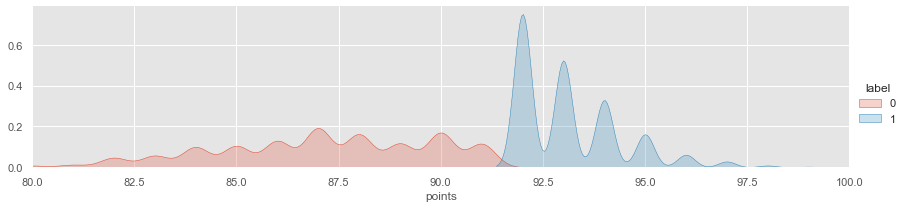

In [15]:
facet = sns.FacetGrid(df_wine,hue="label" , aspect=4)
facet.map(sns.kdeplot,'points',shade=True)
facet.set(xlim=(df_wine['points'].min(),df_wine['points'].max()))
facet.add_legend()
plt.show()

In [16]:
# 추천 비추천간 비율 확인
df_wine['label'].value_counts()/df_wine.shape[0]

0    0.792691
1    0.207309
Name: label, dtype: float64

### EDA10
 * CATEGORICAL featrue의 label(추천/비추천)별 분포확인

In [17]:
def bar_chart(feature):
    recom    = df_wine[df_wine['label']==1][feature].value_counts().head(10)
    unrecom  = df_wine[df_wine['label']==0][feature].value_counts().head(10)
    df = pd.DataFrame([recom,unrecom])
    df.index = ['Recommand','Unrecommand']
    df.plot(kind='bar',stacked=False, figsize=(10,5),title=feature)

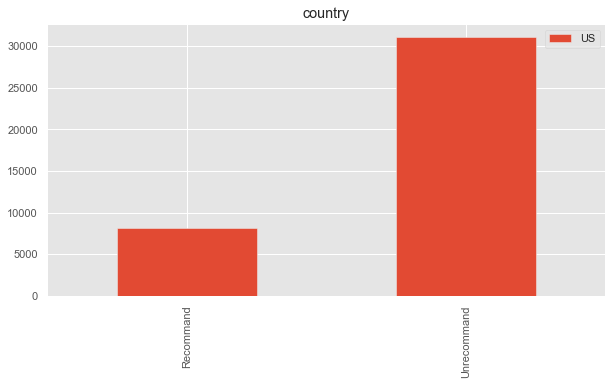

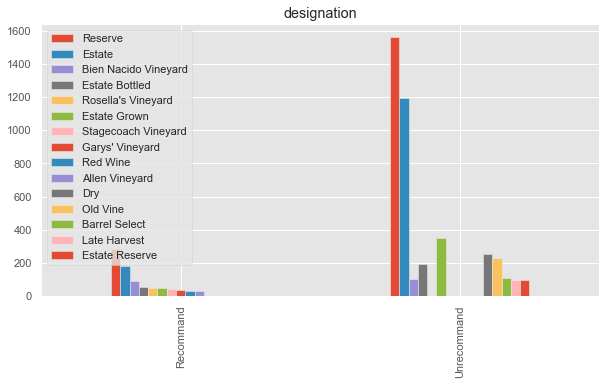

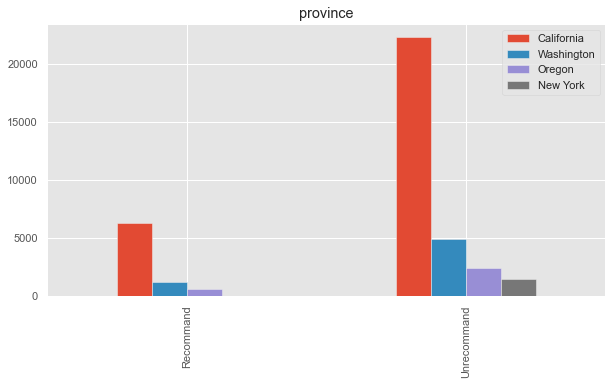

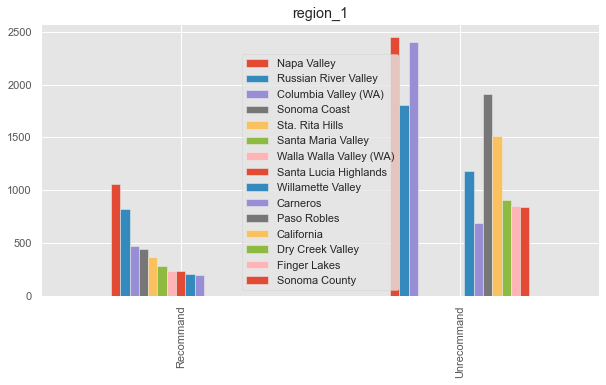

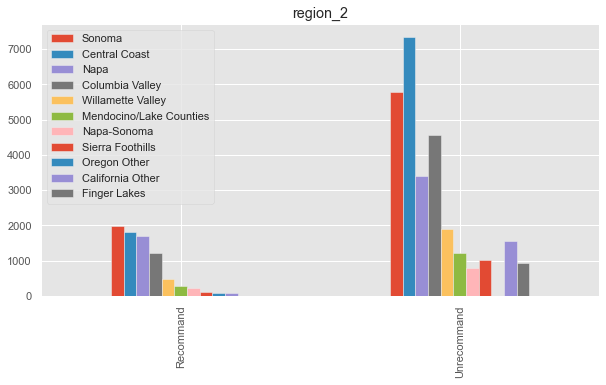

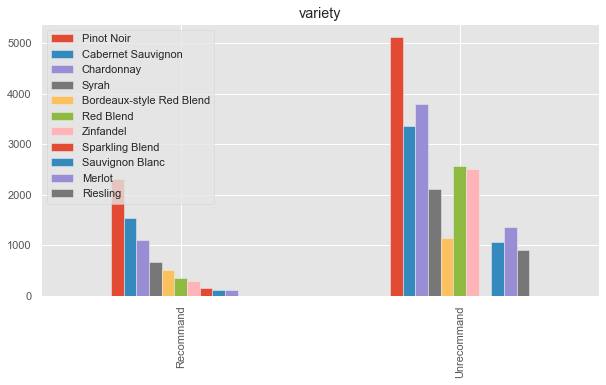

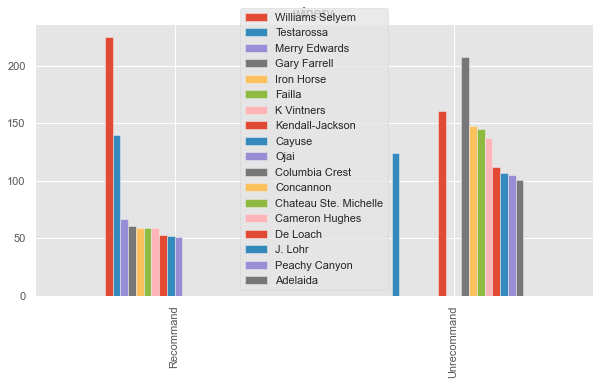

In [18]:
for col_nm in CATEGORICAL_COLUMNS:
    if col_nm != 'description':
        bar_chart(col_nm)

## 더미변수 추가 및 x,y 추출

In [19]:
# 메모리 오류로 인해 df_wine_size  만큼만 읽어 온다
df_wine = df_wine[:df_wine_size]
y = df_wine[LABEL_COLUMN].values
df_wine.pop(LABEL_COLUMN)
df_wine.pop("points")
df_wine_cat = pd.get_dummies(df_wine, columns=[x for x in CATEGORICAL_COLUMNS])
# CATEGORICAL feature 가 아닌 price를 합친다.
df_wine = pd.concat([df_wine_cat,df_wine['price']],axis=1)
print(df_wine.shape)
x = df_wine.values
# split train, test

(10000, 16957)


## WideAndDeep 모델정의

In [20]:
class WideAndDeep:
    def __init__(self, args):
        self.learning_rate = args.learning_rate
        self.epochs = args.epochs
        self.batch_size = args.batch_size
        self.input_dim = args.input_dim
        self.model = self.classifier()

    def classifier(self):
        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)

        # wide part
        wide = Input(shape=(self.input_dim,))

        # deep part
        deep_input = Input(shape=(self.input_dim,))
        deep = Dense(100, activation='relu')(deep_input)
        deep = Dense(50, activation='relu')(deep)

        # concatenate : wide and deep
        wide_n_deep = concatenate([wide, deep])
        wide_n_deep = Dense(1, activation='sigmoid')(wide_n_deep)
        model = Model(inputs=[wide, deep_input], outputs=wide_n_deep)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

    def fit(self, wide_x, deep_x, y):
        self.model.fit([wide_x, deep_x], y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)

    def print_performance(self, wide_x, deep_x, y):
        performance_test = self.model.evaluate([wide_x, deep_x], y, batch_size=self.batch_size)
        print('Test Loss and Accuracy ->', performance_test)

**모델예측 성능 평가를 위한 function을 정의함**

In [21]:
from sklearn.metrics import accuracy_score , precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , y_pred):
    confusion = confusion_matrix(y_test , y_pred)
    accuracy  = accuracy_score(y_test , y_pred)
    precision = precision_score(y_test , y_pred)
    recall    = recall_score(y_test , y_pred)
    print('confusion_matrix')
    print(confusion)
    display(pd.DataFrame(data=[accuracy,precision,recall],index=['accuracy','precision','recall'],columns=['value']).T)
    return [accuracy,precision,recall]

## 모델학습수행
 * 추천 / 비추천 간 비율 이 20 / 80 이므로 class imbalance problem이 발생가능하여 
   StratifiedKFold을 이용 trainset , testset을 층화추출하여 3회 학습 및 예측성능을 평가하여 평균을 낸다

In [22]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=3)

fin_result =[]
for train_indx , test_index in skfold.split(x,y):
    x_train , x_test = x[train_indx] , x[test_index]
    y_train , y_test = y[train_indx] , y[test_index]

    args = easydict.EasyDict({
        "batch_size": 500,
        "epochs": 30,
        "learning_rate": 0.001,
        "input_dim": x_train.shape[1]
    })
    
    # 학습 및 예측
    wide_n_deep = WideAndDeep(args)
    wide_n_deep.fit(x_train, x_train, y_train)
    wide_n_deep.print_performance(x_test, x_test, y_test)
    
    #반복시 마다 정확도 측정
    y_pred = wide_n_deep.model.predict([x_test, x_test])
    #y_pred = get_prob(y_pred)

    # threshold 를 0.5 로 주어 0.5보다 클경우 1 (추천) , 작을겨우 0 (비추천)
    thd = 0.5
    binarizer = Binarizer(threshold=thd)
    y_pred_fin = binarizer.fit_transform(y_pred)

    eval_result = get_clf_eval(y_test,y_pred_fin)
    fin_result.append(eval_result)

Epoch 1/30
11/11 [==============================] - 4s 305ms/step - loss: 0.7850 - accuracy: 0.3287 - val_loss: 0.7138 - val_accuracy: 0.7106
Epoch 2/30
11/11 [==============================] - 1s 125ms/step - loss: 0.6386 - accuracy: 0.7850 - val_loss: 0.7074 - val_accuracy: 0.7106
Epoch 3/30
11/11 [==============================] - 1s 114ms/step - loss: 0.6144 - accuracy: 0.7806 - val_loss: 0.6600 - val_accuracy: 0.7106
Epoch 4/30
11/11 [==============================] - 1s 121ms/step - loss: 0.6012 - accuracy: 0.7782 - val_loss: 0.6553 - val_accuracy: 0.7106
Epoch 5/30
11/11 [==============================] - 1s 126ms/step - loss: 0.5728 - accuracy: 0.7850 - val_loss: 0.6313 - val_accuracy: 0.7106
Epoch 6/30
11/11 [==============================] - 2s 142ms/step - loss: 0.5458 - accuracy: 0.7805 - val_loss: 0.5940 - val_accuracy: 0.7106
Epoch 7/30
11/11 [==============================] - 2s 148ms/step - loss: 0.4927 - accuracy: 0.7844 - val_loss: 0.5373 - val_accuracy: 0.7159
Epoch 

,accuracy,precision,recall
value,0.745351,0.469035,0.659411


Epoch 1/30
11/11 [==============================] - 3s 173ms/step - loss: 0.7731 - accuracy: 0.3468 - val_loss: 0.7221 - val_accuracy: 0.7106
Epoch 2/30
11/11 [==============================] - 1s 125ms/step - loss: 0.6303 - accuracy: 0.7831 - val_loss: 0.7095 - val_accuracy: 0.7106
Epoch 3/30
11/11 [==============================] - 1s 128ms/step - loss: 0.6150 - accuracy: 0.7736 - val_loss: 0.6611 - val_accuracy: 0.7106
Epoch 4/30
11/11 [==============================] - 1s 136ms/step - loss: 0.5909 - accuracy: 0.7797 - val_loss: 0.6617 - val_accuracy: 0.7106
Epoch 5/30
11/11 [==============================] - 1s 118ms/step - loss: 0.5579 - accuracy: 0.7874 - val_loss: 0.6111 - val_accuracy: 0.7106
Epoch 6/30
11/11 [==============================] - 2s 140ms/step - loss: 0.5178 - accuracy: 0.7846 - val_loss: 0.5591 - val_accuracy: 0.7106
Epoch 7/30
11/11 [==============================] - 2s 146ms/step - loss: 0.4465 - accuracy: 0.7837 - val_loss: 0.4956 - val_accuracy: 0.7519
Epoch 

,accuracy,precision,recall
value,0.771377,0.515755,0.398207


Epoch 1/30
11/11 [==============================] - 4s 287ms/step - loss: 0.6490 - accuracy: 0.7746 - val_loss: 0.6466 - val_accuracy: 0.7571
Epoch 2/30
11/11 [==============================] - 1s 134ms/step - loss: 0.6321 - accuracy: 0.7710 - val_loss: 0.6326 - val_accuracy: 0.7571
Epoch 3/30
11/11 [==============================] - 1s 116ms/step - loss: 0.6108 - accuracy: 0.7693 - val_loss: 0.6104 - val_accuracy: 0.7571
Epoch 4/30
11/11 [==============================] - 1s 120ms/step - loss: 0.5731 - accuracy: 0.7724 - val_loss: 0.5732 - val_accuracy: 0.7571
Epoch 5/30
11/11 [==============================] - 1s 121ms/step - loss: 0.5163 - accuracy: 0.7674 - val_loss: 0.5242 - val_accuracy: 0.7594
Epoch 6/30
11/11 [==============================] - 1s 116ms/step - loss: 0.4302 - accuracy: 0.7971 - val_loss: 0.4892 - val_accuracy: 0.7609
Epoch 7/30
11/11 [==============================] - 1s 119ms/step - loss: 0.3633 - accuracy: 0.8547 - val_loss: 0.4873 - val_accuracy: 0.7646
Epoch 

,accuracy,precision,recall
value,0.790279,0.61157,0.284615


## 최종결과확인

In [23]:
fin_result_df = pd.DataFrame(data=fin_result , columns=['accuracy','precision','recall'])
display(fin_result_df)
display(fin_result_df.mean())

,accuracy,precision,recall
0,0.745351,0.469035,0.659411
1,0.771377,0.515755,0.398207
2,0.790279,0.611570,0.284615


accuracy     0.769002
precision    0.532120
recall       0.447411
dtype: float64